In [1]:
import pairTrade
from pairTrade import pairTrade
import pandas as pd
import warnings
import pandas.util.testing as tm
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts 
warnings.filterwarnings('ignore')

symbols = pd.read_csv(f"/Users/jochien/Documents/MaxRereach/pair-trade/rawdata/1D/symbols.csv").symbol.tolist()
df = ((pd.concat([pd.read_csv(f"/Users/jochien/Documents/MaxRereach/pair-trade/rawdata/1D/{symbol}.csv", index_col='date', parse_dates=True)
        ['close'].rename(symbol)for symbol in symbols],axis=1,sort=True)))
df = df.loc[:,~df.columns.duplicated()]

In [ ]:
norm_prices = df.divide(df.iloc[0])

plt.figure(figsize = (15, 10))
plt.plot(norm_prices)
plt.xlabel('days')
plt.title('Performance of cryptocurrencies')
plt.legend(symbols)
plt.show()

result_list = []
for a1 in df.columns:
    for a2 in df.columns:
        if a1 != a2:
            test_result = ts.coint(df[a1], df[a2])
            if test_result[1] < 0.05:
                print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))
                result_list.append((a1, a2, test_result[1]))

* tradeType(ratio, spread, returnSpread, regression)
* strategyType: convergence 收斂策略, divergence 發散策略
* actionType: amount等金額購買, unit依比例購買
* entry 進場條件
* exit 出場條件
* stopLoss 訊號停損
* singalStopLoss{固定停利停損 : stopLoss, 移動停利停損 : trailingStop, 時間停利停損 : timeStop} 
* stopLossPara 停損參數 : stopLoss 固定停利停損點位, trailingStop 移動停利停損點位, timeStop 時間停利停損時間間隔

# Ratio

### singal stoploss

BTCUSDT_ETHUSDT 回測結果，場上有單已平倉
-----------------------------BTCUSDT-ETHUSDT--------------------------
初始價格 100000
總損益:  -40690.68240988
總交易次數:  44
平均損益:  -924.7882365881923
勝率:  0.5909090909090909
獲利因子:  0.5580094685579287
賺賠比:  0.38631424746318144
最大資金回落:  55037.76598679693
夏普比率:  -0.16891929048683527


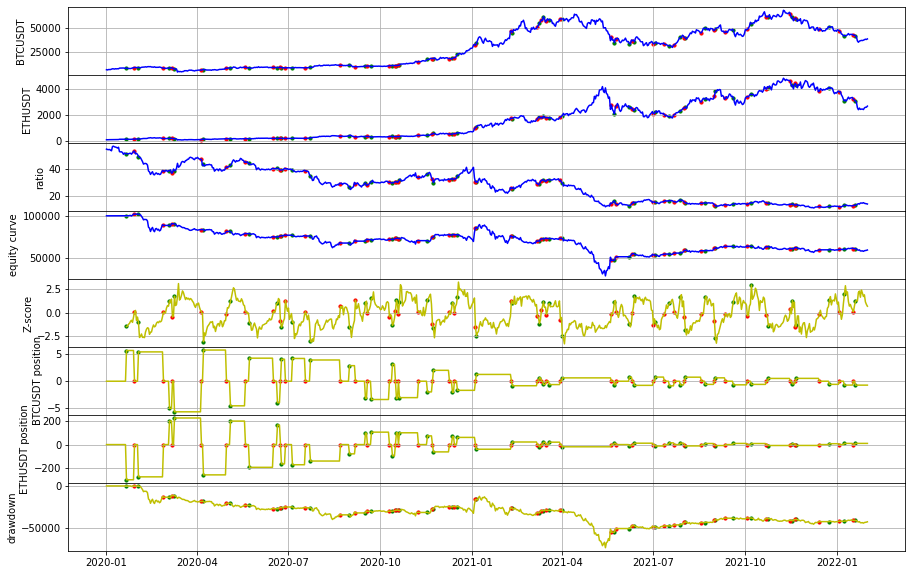

In [2]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['BTCUSDT', 'ETHUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'convergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = None)
A.pplot()

In [ ]:
A.df

In [ ]:
max(A.df['zscore'].dropna())

In [ ]:
A.df['zscore'].dropna()

### stopLoss

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# Spread

### singal stoploss

In [ ]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2)
A.pplot()

### stopLoss

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# returnSpread

### singal stoploss

In [ ]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2)
A.pplot()

### stopLoss

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# regression

### singal stoploss

In [ ]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, signalStopLoss = 1.2)
A.pplot()

### stopLoss

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

In [ ]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, signalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

In [ ]:
        self.df['A_position'] = actionObject.A_positionList
        self.df['B_position']

In [ ]:
currStatus = 0 if (pastStatus == 1 and row['zscore'] < -self.exit) or (pastStatus == -1 and row['zscore'] > self.exit) else 1 if (pastStatus == 1 and row['zscore'] > self.exit or row['zscore'] > self.entry) and row['zscore'] < self.singalStopLoss else 2 if row['zscore'] > self.singalStopLoss else -1 if (pastStatus == -1 and row['zscore'] < -self.exit or row['zscore'] < -self.entry) and row['zscore'] > -self.singalStopLoss else -2 if row['zscore'] < -self.singalStopLoss else 0
currStatus = 0 if (pastStatus == 1 and row['zscore'] < -self.exit) or (pastStatus == -1 and row['zscore'] > self.exit) else 1 if (pastStatus == 1 and row['zscore'] > self.exit or row['zscore'] > self.entry) else -1 if (pastStatus == -1 and row['zscore'] < -self.exit or row['zscore'] < -self.entry) else 0